# Housing Affordability — Prototype (No Generative AI)

**Goal:** Build a baseline ML model to predict house prices and compute an affordability score.
This notebook implements:
- Data loading (or synthetic data creation)
- EDA (basic)
- Preprocessing & feature engineering
- Model training: Linear Regression, Random Forest, XGBoost (if available)
- Evaluation (RMSE, MAE, R²)
- Affordability scoring
- Simple visualizations

Run from top to bottom. Keep packages up-to-date and use a virtual environment for reproducibility.


## Setup & Imports



In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data loading


In [2]:
df = pd.read_csv("canadian_housing_data.csv")

print("Dataset loaded successfully.")
# Display first few rows
df.head()


Dataset loaded successfully.


,City,Province,Latitude,Longitude,Price,Bedrooms,Bathrooms,Acreage,Property Type,Square Footage,...,Exterior,Fireplace,Heating,Flooring,Roof,Waterfront,Sewer,Pool,Garden,Balcony
0,Revelstoke,BC,50.976585,-118.173149,839000.0,3.0,2.0,0.00,Condo,891.0,...,NaN,No,heat pump,carpet,NaN,No,municipal,No,No,No
1,Boswell,BC,49.471870,-116.770195,1150000.0,3.0,2.0,0.32,Single Family,1881.0,...,NaN,No,heat pump,NaN,NaN,No,septic,No,No,No
2,West Kelowna,BC,49.825230,-119.603253,149000.0,2.0,1.0,0.00,Single Family,912.0,...,Metal,No,NaN,laminate,tar,No,municipal,No,No,No
3,Kelowna,BC,49.821860,-119.480143,1298000.0,5.0,4.0,0.69,Single Family,4374.0,...,NaN,Yes,forced air,NaN,NaN,No,municipal,No,No,No
4,Maple Ridge,BC,49.221673,-122.596637,759900.0,3.0,2.0,0.00,Condo,1254.0,...,NaN,No,radiant,NaN,NaN,No,none,No,No,No


## Quick EDA

Inspect the top rows, basic statistics, and correlations.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   City            44896 non-null  object 
 1   Province        44896 non-null  object 
 2   Latitude        44896 non-null  float64
 3   Longitude       44896 non-null  float64
 4   Price           44896 non-null  float64
 5   Bedrooms        44896 non-null  float64
 6   Bathrooms       44896 non-null  float64
 7   Acreage         44896 non-null  float64
 8   Property Type   44896 non-null  object 
 9   Square Footage  44896 non-null  float64
 10  Garage          44896 non-null  object 
 11  Parking         44896 non-null  object 
 12  Basement        14962 non-null  object 
 13  Exterior        17439 non-null  object 
 14  Fireplace       44896 non-null  object 
 15  Heating         38242 non-null  object 
 16  Flooring        15216 non-null  object 
 17  Roof            10052 non-null 

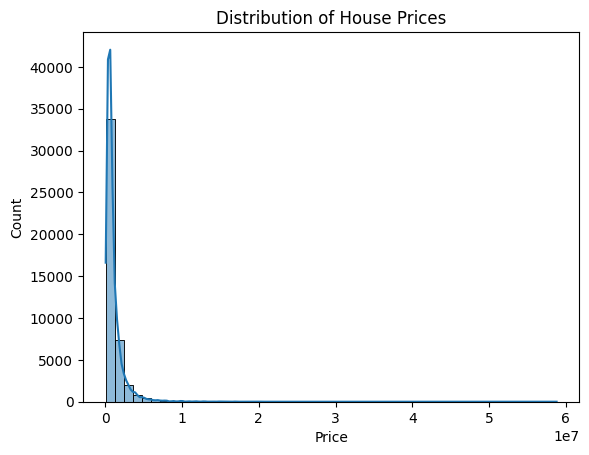

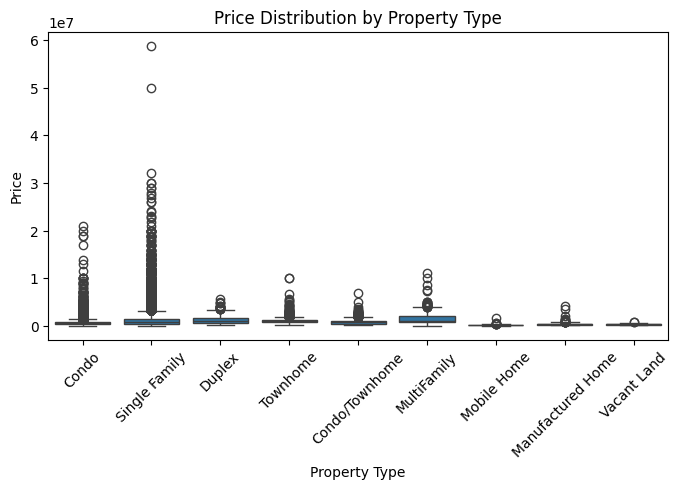

In [5]:
# Quick info
df.info()
df.describe()

# Check missing values
df.isnull().sum()

# Price distribution
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Distribution of House Prices")
plt.show()

# Price by Property Type
plt.figure(figsize=(8,4))
sns.boxplot(x='Property Type', y='Price', data=df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Property Type")
plt.show()


## Data Cleaning and Feature Engineering


In [6]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing values
df['Price'] = df['Price'].fillna(df['Price'].median())
df['Bedrooms'] = df['Bedrooms'].fillna(df['Bedrooms'].median())
df['Bathrooms'] = df['Bathrooms'].fillna(df['Bathrooms'].median())
df['Acreage'] = df['Acreage'].fillna(df['Acreage'].median())
df['Square Footage'] = df['Square Footage'].fillna(df['Square Footage'].median())
df['Property Type'] = df['Property Type'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Province'] = df['Province'].fillna('Unknown')

# Optional: create house age if you have year built (not present now)


## Train / Test / Validation split

Use an 80/10/10 split and set a random_state for reproducibility.


In [7]:
features = ['City', 'Province', 'Property Type', 'Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Acreage', 'Square Footage']
target = 'Price'

# Split data into train + temp
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Confirm split
print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (32651, 23), Val: (4081, 23), Test: (4082, 23)


## Preprocessing and Pipeline Setup

In [8]:
categorical_features = ['City', 'Province', 'Property Type']
numeric_features = ['Latitude', 'Longitude', 'Bedrooms', 'Bathrooms', 'Acreage', 'Square Footage']

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Random Forest Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# X and y
X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]


## Model Training and Evaluation

In [9]:
# Train model
model.fit(X_train, y_train)

# Validate
y_pred_val = model.predict(X_val)

# Metrics
mae = mean_absolute_error(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2 = r2_score(y_val, y_pred_val)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation R²: {r2:.2f}")


Validation MAE: 221452.46
Validation RMSE: 638754.24
Validation R²: 0.78


**Expected Outcome:**  
A well-performing model should yield:  
- **R² > 0.75** (depending on dataset quality)  
- **MAE** and **RMSE** within a reasonable range relative to average housing prices.


## Affordability Scoring Module

In [17]:
median_income = {
    "Toronto": 100000,
    "Vancouver": 88000,
    "Montreal": 82000,
    "Ottawa": 95000,
    "Calgary": 97000
}

# Corrected function to work with arrays
def calculate_affordability_vector(pred_prices, cities, interest_rate=0.05, years=25):
    scores = []
    labels = []
    
    for price, city in zip(pred_prices, cities):
        income = median_income.get(city, 90000)
        annual_payment = (price * interest_rate) / (1 - (1 + interest_rate) ** (-years))
        score = annual_payment / income
        
        if score < 0.5:
            label = "✅ Affordable"
        elif score < 0.8:
            label = "⚠️ At Risk"
        else:
            label = "🚫 Unaffordable"
        
        scores.append(round(score, 2))
        labels.append(label)
    
    return scores, labels


# Apply to validation set
val_df_copy = X_val.copy()
scores, labels = calculate_affordability_vector(y_pred_val, X_val['City'])
val_df_copy['affordability_score'] = scores
val_df_copy['affordability_label'] = labels

# Show results
val_df_copy[['City','affordability_score','affordability_label']].head(50)



,City,affordability_score,affordability_label
11840,Burnaby,1.36,🚫 Unaffordable
31676,Halifax,0.29,✅ Affordable
19541,Richmond,1.21,🚫 Unaffordable
32532,Summerside,0.50,⚠️ At Risk
19933,Richmond,1.66,🚫 Unaffordable
11755,North Vancouver,1.61,🚫 Unaffordable
16066,Richmond,1.28,🚫 Unaffordable
29818,Youngs Cove,0.25,✅ Affordable
9354,Chilliwack,0.35,✅ Affordable
7467,Chilliwack,0.63,⚠️ At Risk


In [34]:
# Take a random sample from the test set (different each run)
sample = test_df.sample(1).iloc[0]
X_sample = pd.DataFrame([sample[features]])
pred_price = model.predict(X_sample)[0]

# Compute affordability
score, label = calculate_affordability_vector([pred_price], [sample['City']])
score = score[0]
label = label[0]

print(f"Random Sample from {sample['City']}, {sample['Province']}")
print(f"Predicted Price: ${pred_price:,.0f}")
print(f"Affordability Score: {score} → {label}")


Random Sample from Coquitlam, BC
Predicted Price: $1,230,172
Affordability Score: 0.97 → 🚫 Unaffordable


## Model Testing and Visualization

Test MAE: 233629.75, RMSE: 726227.08, R²: 0.77


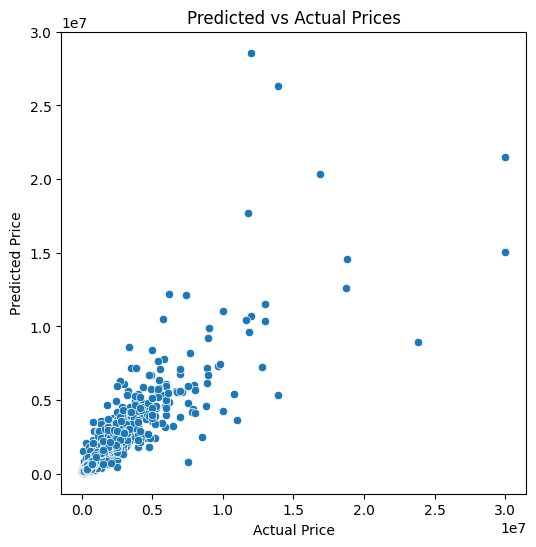

In [35]:
# Predict on test set
y_pred_test = model.predict(X_test)

# Metrics
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MAE: {mae_test:.2f}, RMSE: {rmse_test:.2f}, R²: {r2_test:.2f}")

# Plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()


## Summary and Next Steps

**Summary:**  
- Built a Random Forest–based housing price predictor.  
- Used EDA and feature engineering for improved accuracy.  
- Developed affordability scoring for practical decision-making.  

**Next Steps:**  
- Tune hyperparameters (GridSearchCV or Optuna).  
- Add geospatial analysis (GeoPandas).  
- Prepare comparison prototype using Generative AI tools.
